# **Podcast Data Analysis and Recommendation**

This is Thmanyah Podcast's Assigment which contains Three types of datasets:
- **users.csv** contains the users info
- **episodes.csv** contains the episodes info
- **listens.json** conatins the records for each episode listeners

This notebook is devided into three sections:
## Table of Contents
1. [Data Processing](#data-processing)
2. [Exploratory Data Analysis](#eda)
  - [Q1: The most listened to categories](#q1)
  - [Q2: Listening duration differences by gender](#q2)
  - [Q3: The average number of episodes per user](#q3)
  - [Q4: The most listened categories per gender](#q4)
  - [Q5: Top listening countries & their preferred categories](#q5)
  - [Q6: The most listening age group](#q6)
  - [Q7: The most popular duration time for episodes](#q7)
3. [Personalized Recommendation Generation](#rec)
  - [Demography-based](#demo)
  - [Age Group-based](#age)

### Setting the dependencies and importings

In [1]:
from IPython.display import clear_output
!gdown '1o2T_6eoP2HCKDjV5-4KMSpI5Hvle6TvD'
!unzip assignment.zip -d data
!pip install arabic-reshaper python-bidi
!git clone https://github.com/aliftype/amiri.git
clear_output() #Comment this to see logs if there is an error

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from matplotlib import font_manager
import warnings
warnings.filterwarnings('ignore') #again remove this is if you want to see warnings

#for a better Arabic font :))
font_path = "./amiri/fonts/Amiri-Regular.ttf"
font_prop = font_manager.FontProperties(fname=font_path)

## **Data Processing** <a name="data-processing"></a>

In [3]:
#read all the three datasets
users_df = pd.read_csv('./data/users.csv')
episodes_df = pd.read_csv('./data/episodes.csv')
listens_df = pd.read_json('./data/listens.json')

In [4]:
print(users_df.info(), end="\n"+50*"-"+"\n")
print(episodes_df.info(),end="\n"+50*"-"+"\n")
print(listens_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  20 non-null     int64 
 1   age      20 non-null     int64 
 2   gender   20 non-null     object
 3   country  20 non-null     object
dtypes: int64(2), object(2)
memory usage: 772.0+ bytes
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   episode_id  30 non-null     int64 
 1   title       30 non-null     object
 2   category    30 non-null     object
dtypes: int64(1), object(2)
memory usage: 852.0+ bytes
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
--- 

In [60]:
#Check datasets values validity
#Users Dataset
print("Number of unique ids :",users_df['user_id'].nunique())
print("Number of unique ages :",users_df['age'].nunique())
print("Number of unique genders :",users_df['gender'].nunique(),'genders that are',users_df['gender'].unique())
print("Number of unique countries :",users_df['country'].nunique(),'countries that are',users_df['country'].unique())
#Check the range of the ages
users_df['age'].describe()

Number of unique ids : 20
Number of unique ages : 16
Number of unique genders : 2 genders that are ['female' 'male']
Number of unique countries : 5 countries that are ['Morocco' 'Jordan' 'Saudi Arabia' 'Egypt' 'UAE']


,age
count,20.000000
mean,40.200000
std,11.349009
min,19.000000
25%,31.500000
50%,42.000000
75%,46.500000
max,59.000000


In [62]:
#Episodes Dataset
print("Number of unique ids :",episodes_df['episode_id'].nunique())
print("Number of unique titles :",episodes_df['title'].nunique())
print("Number of unique categories :",episodes_df['category'].nunique(),'categories that are',episodes_df['category'].unique())

Number of unique ids : 30
Number of unique titles : 30
Number of unique categories : 6 categories that are ['Religion' 'Technology' 'Society' 'News' 'Politics' 'Sports']


In [77]:
#Listens Dataset
print("Number of unique ids :",listens_df['user_id'].nunique())
print("Number of unique ids :",listens_df['episode_id'].nunique())
print("Number of unique durations (in seconds) :",listens_df['duration_seconds'].nunique(),'durantion types that are', np.sort(listens_df['duration_seconds'].unique()))
#Check how many 0-durations
print(f"There is {len(listens_df[listens_df['duration_seconds']==0])} zero-durations in the dataset.") #zero-duration indicates that the user didn't listen to anything :))

Number of unique ids : 19
Number of unique ids : 30
Number of unique durations (in seconds) : 7 durantion types that are [   0   60  120  300  900 1500 1800]
There is 13 zero-durations in the dataset.


In [51]:
users_df[~users_df['user_id'].isin(listens_df['user_id'])] #this user has never opened a podcast, not even listened with a zero-duration (not useful line but i was curious :) )

,user_id,age,gender,country
12,13,40,female,Jordan


In [127]:
listens_df=listens_df[listens_df['duration_seconds']>0] #ignore records with zero durations listening

In [128]:
user_episode_df=listens_df.merge(episodes_df, on='episode_id').merge(users_df, on='user_id')
user_episode_df

,user_id,episode_id,duration_seconds,title,category,age,gender,country
0,16,30,60,Episode 30,Sports,24,female,Saudi Arabia
1,6,8,120,Episode 8,Sports,59,male,Morocco
2,6,13,60,Episode 13,Society,59,male,Morocco
3,6,27,1500,Episode 27,News,59,male,Morocco
4,17,9,1500,Episode 9,Sports,21,male,Saudi Arabia
...,...,...,...,...,...,...,...,...
82,16,28,900,Episode 28,News,24,female,Saudi Arabia
83,19,9,60,Episode 9,Sports,42,male,Egypt
84,12,2,1500,Episode 2,Technology,52,female,Jordan
85,1,1,1800,Episode 1,Religion,38,female,Morocco


## **Exploratory Data Analysis (EDA)** <a name="eda"></a>

### Q1: The most listened to categories?<a name="q1"></a>

This indicates that Society and Sports atrracts more than 65% of the listeners.

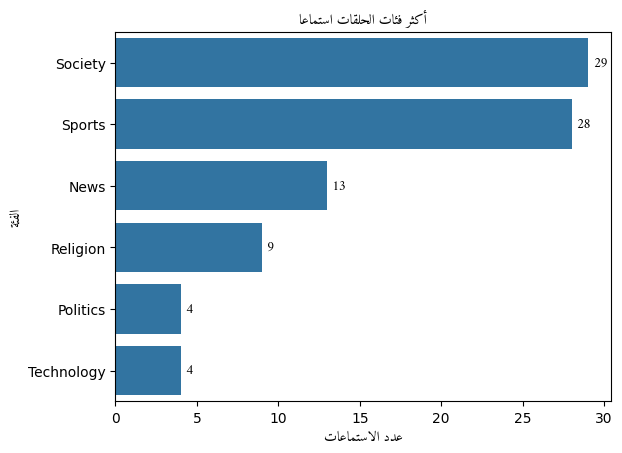

In [129]:
top_categories=user_episode_df.value_counts('category')
sns.barplot(x=top_categories.values, y=top_categories.index)
#I thought to make the figure labels in arabic since the audience are arabs
#the problem is that it's right-to-left langauge, so the text will be reversed,
#but no problem there is a library {arabic_reshaper} to reverse the text so the effect will be cancelled
plt.title(get_display(arabic_reshaper.reshape('أكثر فئات الحلقات استماعًا')),fontproperties=font_prop)
plt.xlabel(get_display(arabic_reshaper.reshape('عدد الاستماعات')),fontproperties=font_prop)
plt.ylabel(get_display(arabic_reshaper.reshape('الفئة')),fontproperties=font_prop)

for i, value in enumerate(top_categories.values):
    plt.text(value + 0.3, i, str(value), va='center', fontsize=10,fontproperties=font_prop)

plt.show()

### Q2: Listening duration differences by gender? <a name="q2"></a>


Generally, females listen to longer episodes compared to males: </br>
~ **15.1 min** for women </br>
~ **10.4 min** for men

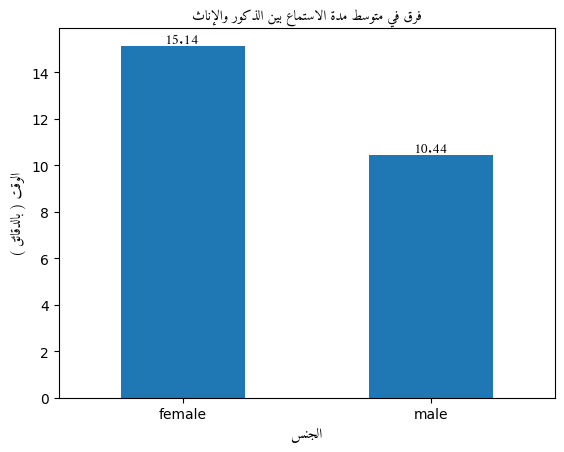

In [141]:
gender_durations_mean=user_episode_df.groupby('gender')['duration_seconds'].mean()/60
gender_durations_mean.plot(kind='bar')
plt.title(get_display(arabic_reshaper.reshape('فرق في متوسط مدة الاستماع بين الذكور والإناث')),fontproperties=font_prop)
plt.xlabel(get_display(arabic_reshaper.reshape('الجنس')),fontproperties=font_prop)
plt.ylabel(get_display(arabic_reshaper.reshape('الوقت ( بالدقائق )')),fontproperties=font_prop)
plt.xticks(rotation=0)

for i, value in enumerate(gender_durations_mean):
    plt.text(i, value , f"{value:.2f}", ha='center', va='bottom', fontsize=10,fontproperties=font_prop)

plt.show()

### Q3: The average number of episodes per user? <a name="q3"></a>


متوسط عدد الحلقات التي يستمع لها المستخدمين هي: 4.579


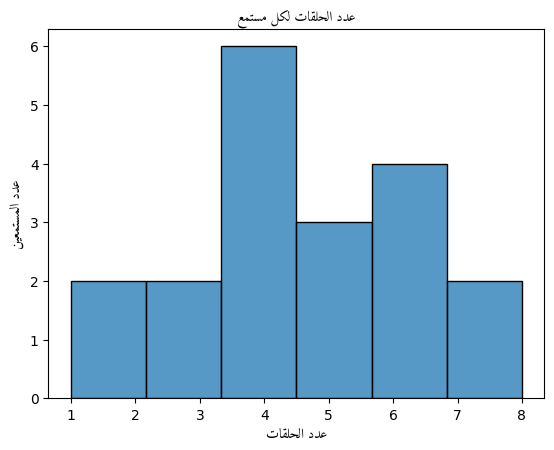

In [134]:
n_episode_per_user=user_episode_df.groupby('user_id').count()['episode_id']
print(f"متوسط عدد الحلقات التي يستمع لها المستخدمين هي: {n_episode_per_user.mean():.3f}")
#plot a histogram for the number of episodes per user
sns.histplot(n_episode_per_user.values,edgecolor='black')
plt.title(get_display(arabic_reshaper.reshape('عدد الحلقات لكل مستمع')),fontproperties=font_prop)
plt.xlabel(get_display(arabic_reshaper.reshape('عدد الحلقات')),fontproperties=font_prop)
plt.ylabel(get_display(arabic_reshaper.reshape('عدد المستمعين')),fontproperties=font_prop)
plt.show()

Additional questions:

### Q4: The most listened categories per gender? <a name="q4"></a>

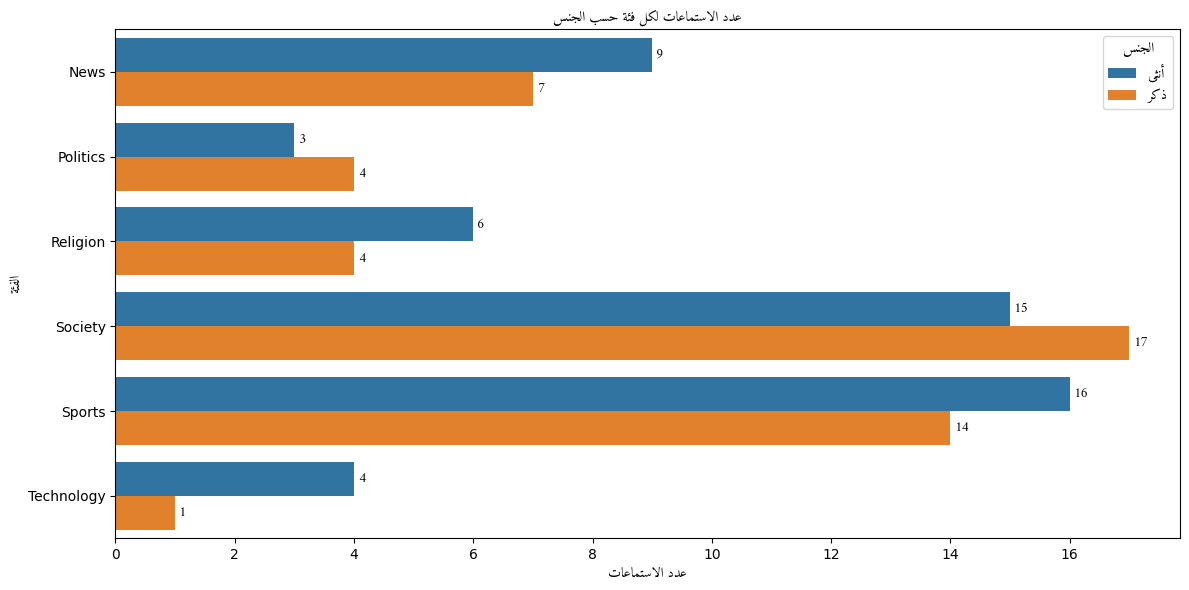

In [17]:
gender_category_counts =user_episode_df.groupby(['gender', 'category']).size().reset_index(name='count')

# english to arabic text converting
gender_map = {
    'female': get_display(arabic_reshaper.reshape('أنثى')),
    'male': get_display(arabic_reshaper.reshape('ذكر'))
}
gender_category_counts['gender'] = gender_category_counts['gender'].map(gender_map)

plt.figure(figsize=(12, 6))
ax=sns.barplot(data=gender_category_counts, x='count', y='category', hue='gender')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3,fontproperties=font_prop)

plt.title(get_display(arabic_reshaper.reshape('عدد الاستماعات لكل فئة حسب الجنس')),fontproperties=font_prop)
plt.xlabel(get_display(arabic_reshaper.reshape('عدد الاستماعات')),fontproperties=font_prop)
plt.ylabel(get_display(arabic_reshaper.reshape('الفئة')),fontproperties=font_prop)
legend=plt.legend(title=get_display(arabic_reshaper.reshape('الجنس')))
legend.get_title().set_fontproperties(font_prop)
for text in legend.get_texts():
    text.set_fontproperties(font_prop)
plt.tight_layout()
plt.show()

 ### Q5: Top listening countries & their preferred categories? <a name="q5"></a>




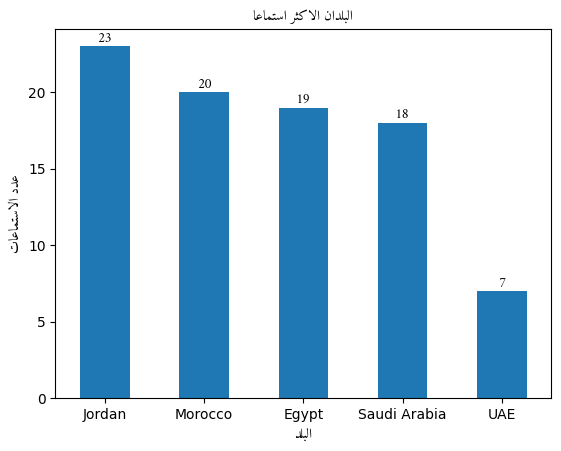

In [135]:
n_listening=user_episode_df.groupby('country').size().sort_values(ascending=False)
n_listening.plot(kind='bar')

plt.title(get_display(arabic_reshaper.reshape('البلدان الاكثر استماعاً')),fontproperties=font_prop)
plt.xlabel(get_display(arabic_reshaper.reshape('البلد')),fontproperties=font_prop)
plt.ylabel(get_display(arabic_reshaper.reshape('عدد الاستماعات')),fontproperties=font_prop)

plt.xticks(rotation=0)

for i, value in enumerate(n_listening):
    plt.text(i, value +0.1, str(value), ha='center', va='bottom', fontsize=10,fontproperties=font_prop)

plt.show()

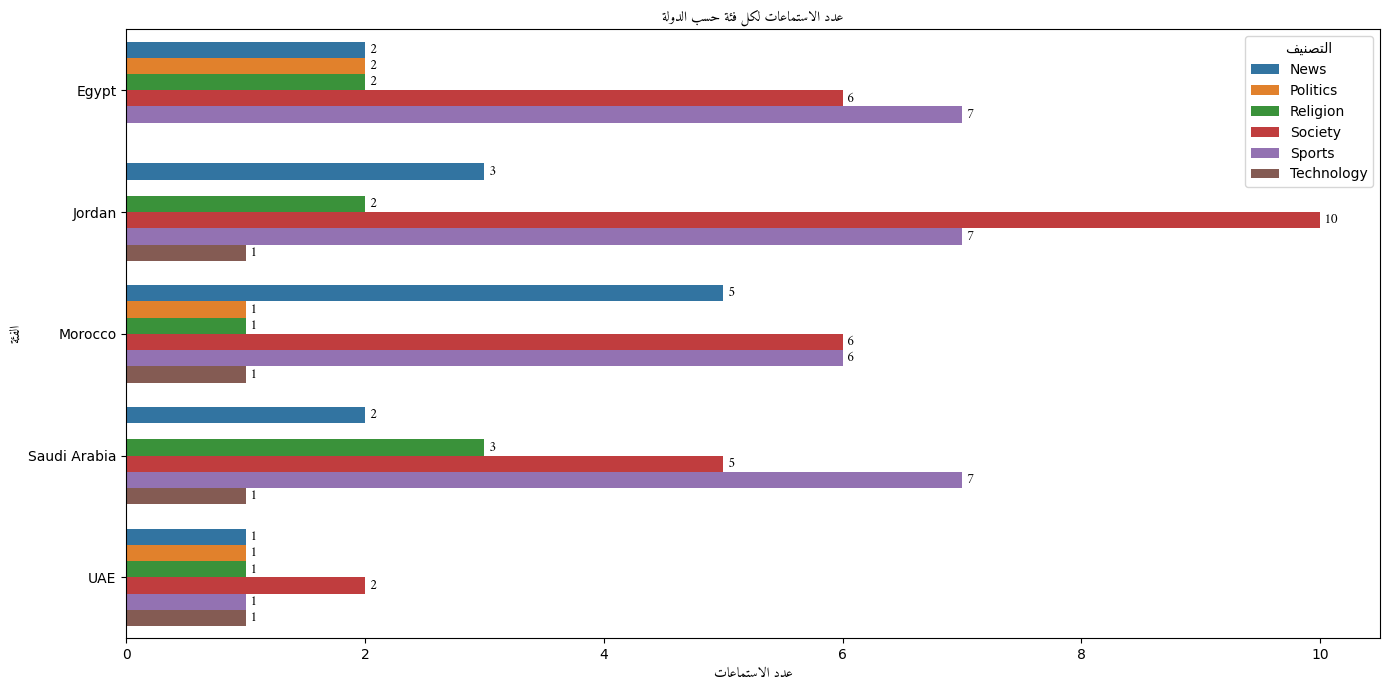

In [136]:
country_category_counts = user_episode_df.groupby(['country', 'category']).size().reset_index(name='count')

plt.figure(figsize=(14, 7))
ax = sns.barplot(data=country_category_counts, x='count', y='country', hue='category')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3,fontproperties=font_prop)

plt.title(get_display(arabic_reshaper.reshape('عدد الاستماعات لكل فئة حسب الدولة')),fontproperties=font_prop)
plt.xlabel(get_display(arabic_reshaper.reshape('عدد الاستماعات')),fontproperties=font_prop)
plt.ylabel(get_display(arabic_reshaper.reshape('الفئة')),fontproperties=font_prop)
plt.legend(title=get_display(arabic_reshaper.reshape('التصنيف')))
legend.get_title().set_fontproperties(font_prop)
plt.tight_layout()
plt.show()

The age of our listeners and how can we categorize them?

In [138]:
youngest_listener=user_episode_df['age'].min()
oldest_listener=user_episode_df['age'].max()
print(f'The youngest listener to Thmanyah is {youngest_listener} years old')
print(f'The oldest listener to Thmanyah is {oldest_listener} years old')

The youngest listener to Thmanyah is 19 years old
The oldest listener to Thmanyah is 59 years old


Let's categorize the listeners to 8 groups:
- 19-24 (at the age of University students)
- 25-30 (looking for more knowledge and job opportunities)
- 31-36 (idk at stable age)
- 37-42 (also stable age)
- 43-48
- 49-54
- 55 and above

In [24]:
def categorize_age(age):
    if 19 <= age <= 24:
        return '19-24'
    elif 25 <= age <= 30:
        return '25-30'
    elif 31 <= age <= 36:
        return '31-36'
    elif 37 <= age <= 42:
        return '37-42'
    elif 43 <= age <= 48:
        return '43-48'
    elif 49 <= age <= 54:
        return '49-54'
    elif age >= 55:
        return '55+'
    else:
        return 'ُUnknown'

In [139]:
user_episode_df['age_group'] = user_episode_df['age'].apply(categorize_age)
user_episode_df

,user_id,episode_id,duration_seconds,title,category,age,gender,country,age_group
0,16,30,60,Episode 30,Sports,24,female,Saudi Arabia,19-24
1,6,8,120,Episode 8,Sports,59,male,Morocco,55+
2,6,13,60,Episode 13,Society,59,male,Morocco,55+
3,6,27,1500,Episode 27,News,59,male,Morocco,55+
4,17,9,1500,Episode 9,Sports,21,male,Saudi Arabia,19-24
...,...,...,...,...,...,...,...,...,...
82,16,28,900,Episode 28,News,24,female,Saudi Arabia,19-24
83,19,9,60,Episode 9,Sports,42,male,Egypt,37-42
84,12,2,1500,Episode 2,Technology,52,female,Jordan,49-54
85,1,1,1800,Episode 1,Religion,38,female,Morocco,37-42


### Q6: The most listening age group? <a name="q6"></a>

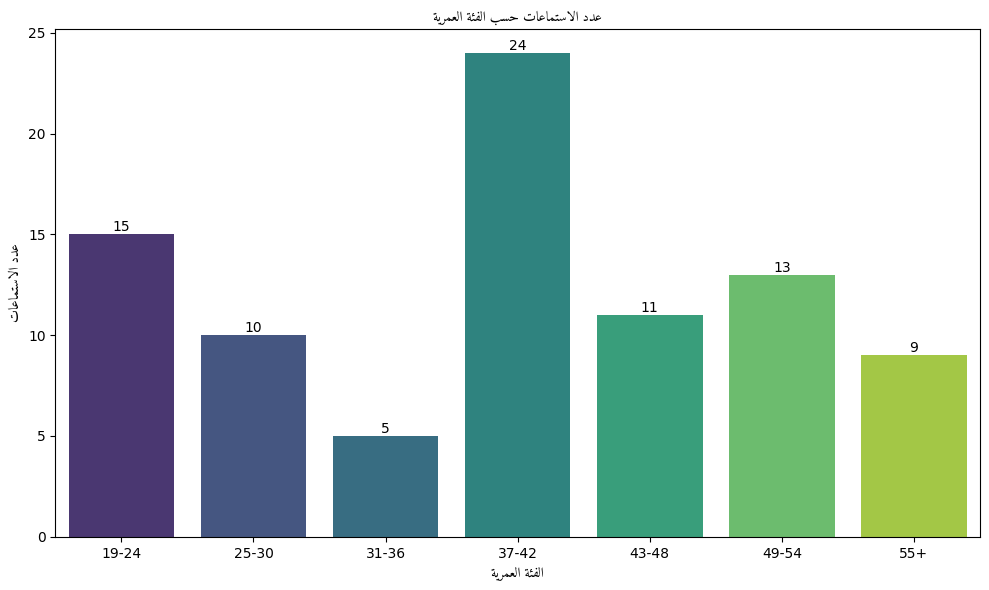

In [140]:
age_group_counts = user_episode_df['age_group'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette='viridis')

for i, val in enumerate(age_group_counts.values):
    ax.text(i, val, str(val), ha='center', va='bottom')

plt.title(get_display(arabic_reshaper.reshape('عدد الاستماعات حسب الفئة العمرية')),fontproperties=font_prop)
plt.xlabel(get_display(arabic_reshaper.reshape('الفئة العمرية')),fontproperties=font_prop)
plt.ylabel(get_display(arabic_reshaper.reshape('عدد الاستماعات')),fontproperties=font_prop)
plt.tight_layout()
plt.show()

### Q7: The most popular duration time for episodes? <a name="q7"></a>

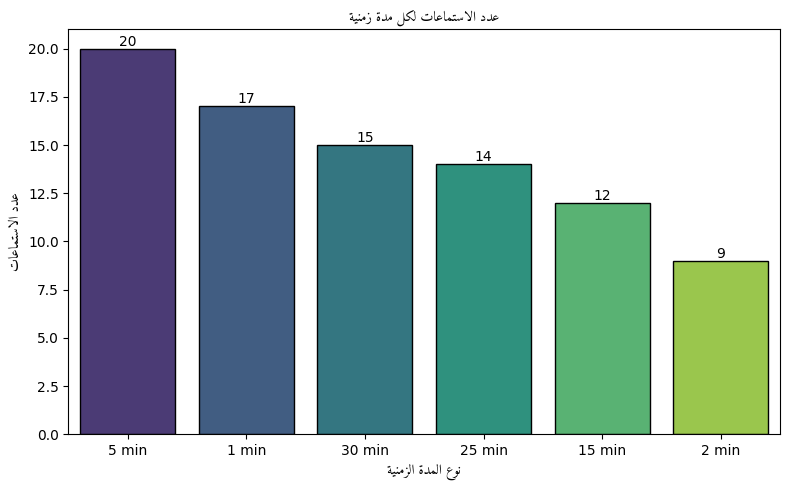

In [171]:
duration_counts = user_episode_df['duration_seconds'].value_counts()

plt.figure(figsize=(8, 5))
ax= sns.barplot(x=(duration_counts.index//60).astype(str)+" min", y=duration_counts.values, edgecolor='black',palette='viridis')

for i, val in enumerate(duration_counts.values):
    ax.text(i, val, str(val), ha='center', va='bottom')

plt.title(get_display(arabic_reshaper.reshape('عدد الاستماعات لكل مدة زمنية')), fontproperties=font_prop)
plt.xlabel(get_display(arabic_reshaper.reshape('نوع المدة الزمنية')), fontproperties=font_prop)
plt.ylabel(get_display(arabic_reshaper.reshape('عدد الاستماعات')), fontproperties=font_prop)

plt.tight_layout()
plt.show()


## **Lets do Recommendation!!** <a name="rec"></a>


In [36]:
def demo_rec(user_id,listens_df, users_df, possible_rec, top_k):
  user_country = users_df[users_df['user_id'] == user_id].iloc[0]['country']
  #similar users from the same country
  similar_users = users_df[users_df['country'] == user_country].merge(listens_df, on='user_id')
  #the similar users must have watch an episode from category that the user loves in {possible_rec}
  similar_users = similar_users[similar_users['episode_id'].isin(possible_rec['episode_id'])]
  #return the top_k watched episode that similar users watched
  return similar_users.value_counts('episode_id').reset_index()['episode_id'][:top_k]


def age_rec(user_id,listens_df, users_df, possible_rec, top_k):
  user_age = users_df[users_df['user_id'] == user_id]['age'][0]
  user_group = categorize_age(user_age)
  if user_group == 'Unknown':
    return pd.DataFrame() #empty dataframe
  users = users_df.copy()
  users['age_group'] = users['age'].apply(categorize_age)
  #similar users from the same age group
  similar_users = users[users['age_group'] == user_group].merge(listens_df, on='user_id')
  #the similar users must have watch an episode from category that the user loves in {possible_rec}
  similar_users = similar_users[similar_users['episode_id'].isin(possible_rec['episode_id'])]
  #return the top_k watched episode that similar users watched
  return similar_users.value_counts('episode_id').reset_index()['episode_id'][:top_k]

In [37]:
def recommend_episodes(user_id: int, listens_df, episodes_df, users_df, method='random',top_k=3):

    user_episodes = listens_df[listens_df['user_id'] == user_id]
    fav_category = user_episodes.merge(episodes_df, on='episode_id', how='left')['category'].value_counts().reset_index()['category'][0]
    list_episodes = episodes_df[episodes_df['category'] == fav_category]
    possible_rec = list_episodes[~list_episodes['episode_id'].isin(user_episodes['episode_id'])]

    if possible_rec.empty:
        return []

    if method == 'demography':
        recommendation= demo_rec(user_id,listens_df,users_df, possible_rec, top_k)

    if method == 'age':
        user_age = users_df[users_df['user_id'] == user_id]['age'][0]
        user_group = categorize_age(user_age)
        if user_group == 'Unknown':
            return pd.DataFrame() #empty dataframe
        users = users_df.copy()
        users['age_group'] = users['age'].apply(categorize_age)
        #similar users from the same age group
        similar_users = users[users['age_group'] == user_group].merge(listens_df, on='user_id')
        #the similar users must have watch an episode from category that the user loves in {possible_rec}
        similar_users = similar_users[similar_users['episode_id'].isin(possible_rec['episode_id'])]
        #get the top_k watched episode that similar users watched
        recommendation= similar_users.value_counts('episode_id').reset_index()['episode_id'][:top_k]

    #suggest random recommendation if demo or age recommendation is empty list
    if method == 'random' or recommendation.empty:
        recommendation = possible_rec['episode_id'].sample(n=min(top_k,len(possible_rec)))

    return recommendation

In [29]:
recommend_episodes(user_id=1, listens_df=listens_df, episodes_df=episodes_df,users_df=users_df, method='random')

,episode_id
10,11
22,23
16,17


##### Demography-based Personalized Recommendation Query <a name="demo"></a>

In [40]:
recommend_episodes(user_id=3, listens_df=listens_df, episodes_df=episodes_df,users_df=users_df, method='demography')

,episode_id
6,7


##### Age-based Personalized Recommendation Query <a name="age"></a>

In [30]:
recommend_episodes(user_id=1, listens_df=listens_df, episodes_df=episodes_df,users_df=users_df, method='age')

,episode_id
0,29
1,9
2,12


Thank you for seeing the code!!<br><br>
**Author:** Lama AlQarni